In [ ]:

# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 

!pip install sahi==0.10.8
!pip install -U pillow

--2022-11-20 03:40:07--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2820 (2.8K) [text/plain]
Saving to: ‘icevision_install.sh’

icevision_install.s 100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-11-20 03:40:07 (54.8 MB/s) - ‘icevision_install.sh’ saved [2820/2820]

Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 1.4 MB/s eta 0:15:50tcmalloc: large alloc 1147494400 bytes == 0x38e50000 @  0x7feba08b5615 0x

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}

In [ ]:
!rm -r CityCam
!rm parse_result
!rm CityCam_Annotations.csv
!rm vehicle_icevision_dataset_truncated.zip
!rm -r models
!rm -r checkpoints

rm: cannot remove 'CityCam': No such file or directory
rm: cannot remove 'parse_result': No such file or directory
rm: cannot remove 'CityCam_Annotations.csv': No such file or directory
rm: cannot remove 'vehicle_icevision_dataset_truncated.zip': No such file or directory
rm: cannot remove 'models': No such file or directory
rm: cannot remove 'checkpoints': No such file or directory


In [ ]:
# Download and Extract Dataset
!gdown 1Exm50EBAi8o5E-M6GMltf-_TL3wbvLeP
!unzip -qq  vehicle_icevision_dataset_truncated_colab.zip 

Downloading...
From: https://drive.google.com/uc?id=1Exm50EBAi8o5E-M6GMltf-_TL3wbvLeP
To: /content/vehicle_icevision_dataset_truncated_colab.zip
100% 906M/906M [00:03<00:00, 278MB/s]


In [ ]:
import os
import pandas as pd

df = pd.read_csv('CityCam_Annotations.csv') 
df   



,img_path,width,height,label,x_min,y_min,x_max,y_max
0,/content/CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,74,88,84,97
1,/content/CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,79,90,93,103
2,/content/CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,97,91,107,102
3,/content/CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,115,91,128,102
4,/content/CityCam/170/170-20160429-15/000230.jpg,352,240,vehicle,104,97,121,107
...,...,...,...,...,...,...,...,...
603940,/content/CityCam/bigbus/bigbus-511/000089.jpg,352,240,vehicle,84,116,103,129
603941,/content/CityCam/bigbus/bigbus-511/000089.jpg,352,240,vehicle,199,110,215,120
603942,/content/CityCam/bigbus/bigbus-511/000089.jpg,352,240,vehicle,186,106,202,115
603943,/content/CityCam/bigbus/bigbus-511/000089.jpg,352,240,vehicle,106,144,133,167


In [ ]:
from icevision.all import *


INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

In [ ]:
template_record = ObjectDetectionRecord()
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_filepath(<Union[str, Path]>)
        record.set_img_size(<ImgSize>)
        record.detection.add_bboxes(<Sequence[BBox]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)


In [ ]:
class VehicleParser(Parser):
    def __init__(self, template_record, df):
        super().__init__(template_record=template_record)


        self.df = df
        self.class_map = ClassMap(list(self.df['label'].unique()))

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.img_path

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(o.img_path)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)

        record.detection.add_bboxes([BBox.from_xyxy(o.x_min, o.y_min, o.x_max, o.y_max)])
        record.detection.add_labels([o.label])

In [ ]:
parser = VehicleParser(template_record, df)

In [ ]:
train_records, valid_records = parser.parse(cache_filepath='./parse_result')

INFO     - Loading cached records from ./parse_result | icevision.parsers.parser:parse:114


In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
!gdown 1-788gMM6t4V2pe4M0ip7sSARGoftrrne

Downloading...
From: https://drive.google.com/uc?id=1-788gMM6t4V2pe4M0ip7sSARGoftrrne
To: /content/vfnet_vehicle_model_2.pth
100% 391M/391M [00:02<00:00, 183MB/s]


In [ ]:
# Just change the value of selection to try another model


extra_args = {}


model_type = models.mmdet.vfnet 
backbone = model_type.backbones.resnet50_fpn_mstrain_2x(pretrained=False)
    
model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.vfnet' from '/usr/local/lib/python3.7/dist-packages/icevision/models/mmdet/models/vfnet/__init__.py'>,
 {})

In [ ]:
# Instantiate the model

model = model_type.model(backbone=backbone(pretrained=False),num_classes=len(parser.class_map))



/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2022-11-20 03:47:09,827 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-11-20 03:47:09,829 - mmcv - INFO - load model from: torchvision://resnet50
2022-11-20 03:47:09,832 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2022-11-20 03:47:10,771 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-11-20 03:47:10,805 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-11-20 03:47:10,835 - mmcv - INFO - initialize VFNetHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'vfnet_cls', 'std': 0.01, 'bias_prob': 0.01}}
2022-11-20 03:47:10,872 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-11-20 03:47:10,873 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-11-20 03:47:10,877 - mmcv - INFO - 
backbone.bn1.bias - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-11-20 03:47:10,880 - mmcv - INFO - 
backbone.layer1.0.conv1.weight - torch.Size([64, 

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=2, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=2, shuffle=False)

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [ ]:
!mkdir models
%cd models/
!gdown 1-788gMM6t4V2pe4M0ip7sSARGoftrrne
%cd ..

/content/models
Downloading...
From: https://drive.google.com/uc?id=1-788gMM6t4V2pe4M0ip7sSARGoftrrne
To: /content/models/vfnet_vehicle_model_2.pth
100% 391M/391M [00:02<00:00, 166MB/s] 
/content


In [ ]:

checkpoint_path = 'vfnet_vehicle_model_2'
learn.load(checkpoint_path)

In [ ]:
from fastai.vision.all import *
#learn.lr_find(suggest_funcs=(minimum,steep,valley,slide))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TSDN2022

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/18L4AHtL_ljPMHBEYd_r-aAKpHsbrddDt/TSDN2022


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


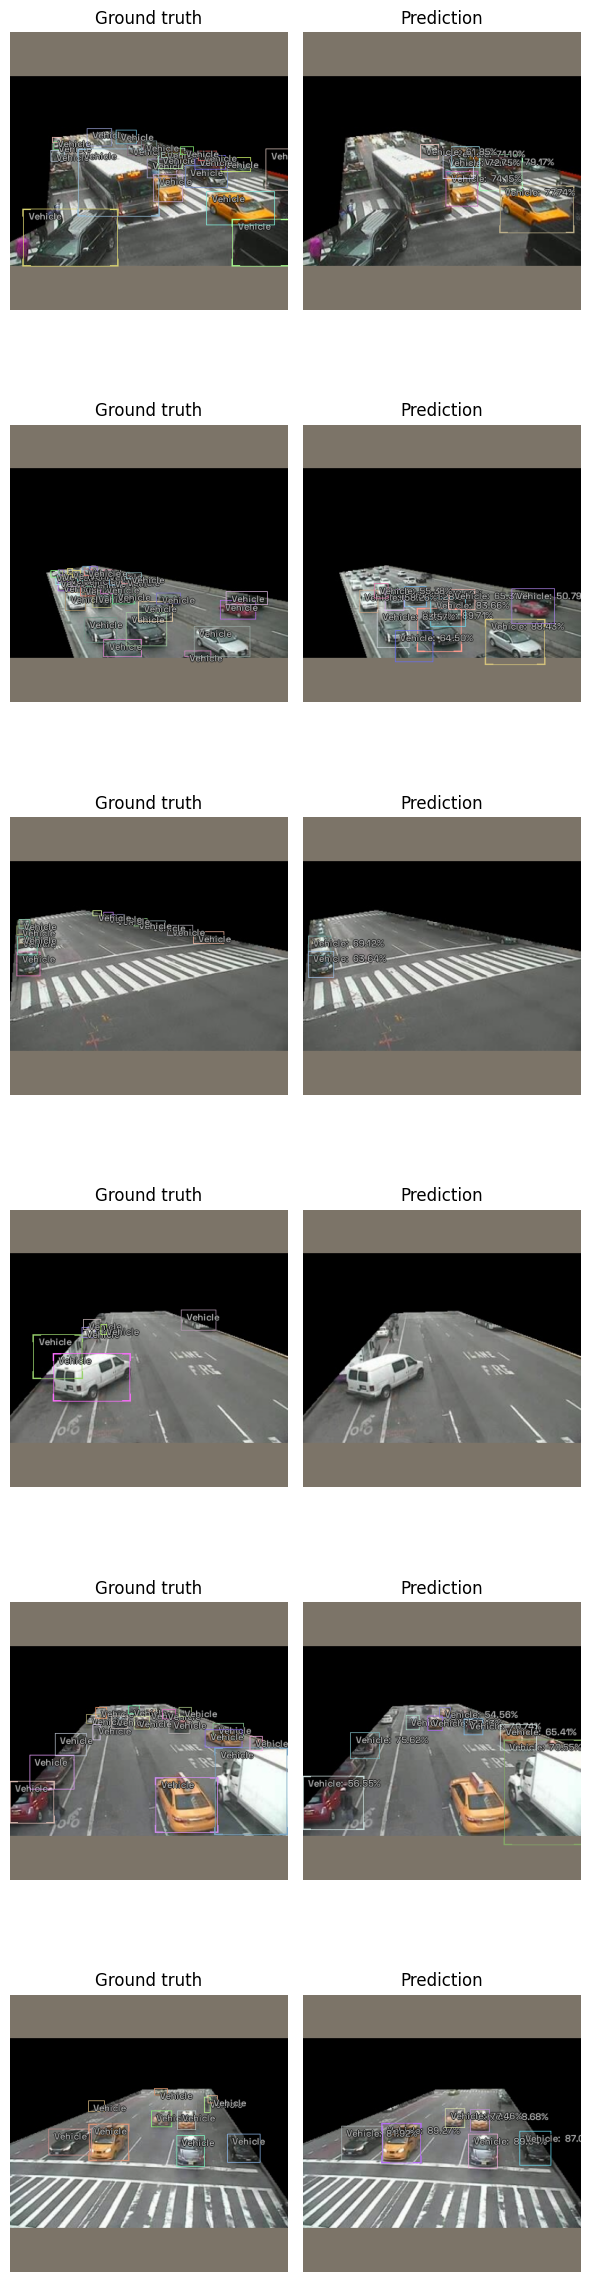

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [ ]:
from icevision.all import *
from icevision.models import *

In [ ]:
checkpoint_path = 'vehicle_icevision_vfnet_full.pth'
save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet', 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        classes =  parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.12.0'})

